#  Deep‐Feature Driven Hybrid Ensemble Framework for Simultaneous Attack Classification and Throughput Regression in 6G Networks

## Importing the Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter
from tkinter import messagebox, filedialog, simpledialog
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, label_binarize, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, 
    precision_score, recall_score, f1_score, accuracy_score, 
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

import joblib
from joblib import dump, load

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Setting up directories
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)

RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)


## Loading the Dataset

In [2]:
def load_dataset():
    """Load the dataset from a CSV file selected via file dialog."""
    filepath = filedialog.askopenfilename(
        initialdir=".",
        title="Select CSV File",
        filetypes=(("CSV files", "*.csv"), ("All files", "*.*"))
    )
    if filepath:
        return pd.read_csv(filepath)
    else:
        print("No file selected.")
        return None

In [3]:
# Load dataset
df = load_dataset()
df

,Slice ID,Slice Type,Slice Bandwidth (Mbps),Latency (ms),Packet Loss Rate (%),Data Rate (Mbps),Traffic Load,Signal Strength,Network Congestion,Transmission Path,...,Attack Type,Security Status,Attack Detection Time (ms),IGJO-SVM Prediction,Adjustment Action,Throughput (Mbps),Energy Efficiency (J/bit),Packet Delivery Ratio (%),End-to-End Delay (ms),Accuracy of Security (%)
0,103,Ultra-High-Speed,644,20,0.044122,457,Medium,Strong,Medium,Path A,...,DDoS,Yes,88,0.784537,Optimize Path,399.941998,0.025629,90.949866,15,92.345441
1,436,IoT,648,13,0.028005,454,Medium,Weak,Medium,Path C,...,Eavesdropping,Yes,38,0.834112,Increase Security,1796.872702,0.014642,96.256672,11,97.477653
2,861,IoT,1759,14,0.058662,1297,Low,Strong,Low,Path A,...,DDoS,Yes,61,0.927561,Alert Admin,565.562162,0.015082,95.697079,25,97.571666
3,271,Autonomous,784,19,0.176483,621,Medium,Strong,Medium,Path B,...,DDoS,No,57,0.742899,Alert Admin,1150.744632,0.037527,91.025846,23,90.478111
4,107,Autonomous,1320,13,0.186623,849,High,Weak,Medium,Path C,...,DDoS,Yes,50,0.830193,Alert Admin,964.880162,0.039606,91.581326,16,98.203450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,290,Ultra-High-Speed,1745,15,0.037482,1639,Medium,Weak,High,Path C,...,Spoofing,Yes,24,0.155648,Increase Security,647.685416,0.017185,90.776479,19,91.507324
4996,295,Autonomous,554,14,0.062870,129,Medium,Strong,Low,Path C,...,Spoofing,No,69,0.316502,Alert Admin,1011.488356,0.043392,95.472374,16,99.176332
4997,451,Autonomous,905,11,0.067772,763,High,Weak,Low,Path B,...,DDoS,Yes,61,0.358145,Optimize Path,1358.393685,0.024247,90.083048,28,97.351158
4998,904,Autonomous,741,8,0.051981,413,Low,Weak,Low,Path C,...,DDoS,Yes,100,0.601411,Optimize Path,1347.469986,0.014414,96.113055,11,92.570062


## Data Preprocessing

In [4]:
def preprocess_data(df, is_train=True, label_encoders=None):

    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # Drop unnamed cols

    if is_train:
        label_encoders = {}

        for col in df.select_dtypes(include='object').columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
    else:
        if label_encoders is None:
            raise ValueError("label_encoders must be provided for test/inference.")

        for col in df.select_dtypes(include='object').columns:
            if col in label_encoders:
                le = label_encoders[col]
                df[col] = le.transform(df[col].astype(str))
            else:
                raise ValueError(f"Missing encoder for column: {col}")

    df = df.fillna(df.mean(numeric_only=True))

    if is_train:
        X = df.drop(columns=['Attack Type', 'Throughput (Mbps)'])
        y = df['Attack Type']
        y1 = df['Throughput (Mbps)']
        return X, y, y1, label_encoders
    else:
        return df

## EDA

In [5]:
def perform_eda(X, y, y1):
    """Perform Exploratory Data Analysis with 5 plots."""
    # Ensure plots are saved and not displayed
    plt.figure(figsize=(15, 10))
    
    # 1. Count Plot of Attack Types
    plt.subplot(2,3,1)
    sns.countplot(x=y)
    plt.title("Distribution of Attack Types")
    plt.xlabel("Attack Type (Encoded)")
    plt.ylabel("Count")
    
    # 2. Box Plot of Latency vs Attack Type
    plt.subplot(2,3,2)
    sns.boxplot(x=y, y=X['Latency (ms)'])
    plt.title("Latency Distribution per Attack Type")
    plt.xlabel("Attack Type (Encoded)")
    plt.ylabel("Latency (ms)")
    
    # 3. Violin Plot: Signal Strength vs Attack Type
    plt.subplot(2,3,3)
    sns.violinplot(x=y, y=X['Signal Strength'])
    plt.title("Signal Strength by Attack Type")
    plt.xlabel("Attack Type (Encoded)")
    plt.ylabel("Signal Strength (Encoded)")
    
    # Regression plots
    # 4. Box Plot: Signal Strength vs Throughput
    plt.subplot(2,3,4)
    sns.boxplot(x=X['Signal Strength'], y=y1)
    plt.title("Throughput by Signal Strength")
    plt.xlabel("Signal Strength (Encoded)")
    plt.ylabel("Throughput (Mbps)")
    
    # 5. Scatter Plot: Latency vs Throughput
    plt.subplot(2,3,5)
    sns.scatterplot(x=X['Latency (ms)'], y=y1)
    plt.title("Throughput vs Latency")
    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughput (Mbps)")
    
    # 6. Correlation Heatmap
    plt.subplot(2,3,6)
    df_corr = X.copy()
    df_corr['Throughput (Mbps)'] = y1

    sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap with Throughput")
    
    plt.tight_layout()
    plt.savefig('results/eda_plots.png')
    plt.show()


## Train Test Splitting

In [6]:
def train_test_splitdata(X, y, y1, test_size=0.2, random_state=42):
    X_train, X_test, y_class_train, y_class_test,y_reg_train, y_reg_test = train_test_split(
        X, y,y1, test_size=test_size, random_state=random_state, stratify=y
    )



    return (
        X_train, X_test, y_class_train, y_class_test,y_reg_train, y_reg_test
    )


## Metrics to calculate the performance of the model

In [7]:
precision = []
recall = []
fscore = []
accuracy = []

labels = ['DDOS','Eavesdropping','Spoofing']

# Dataframes to store results
metrics_df = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
class_report_df = pd.DataFrame()
class_performance_dfs = {}  # Dictionary to store dataframes for each class

if not os.path.exists('results'):
    os.makedirs('results')
    
    
def Calculate_Metrics(algorithm, predict, y_test,y_score):
    global metrics_df, class_report_df, class_performance_dfs
    
    categories = labels
    
    # Calculate overall metrics
    a = accuracy_score(y_test, predict) * 100
    p = precision_score(y_test, predict, average='macro') * 100
    r = recall_score(y_test, predict, average='macro') * 100
    f = f1_score(y_test, predict, average='macro') * 100

    # Append to global lists
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    
    # Create metrics dataframe entry
    metrics_entry = pd.DataFrame({
        'Algorithm': [algorithm],
        'Accuracy': [a],
        'Precision': [p],
        'Recall': [r],
        'F1-Score': [f]
    })
    metrics_df = pd.concat([metrics_df, metrics_entry], ignore_index=True)
    
    # Console output
    print(f"{algorithm} Accuracy  : {a:.2f}")
    print(f"{algorithm} Precision : {p:.2f}")
    print(f"{algorithm} Recall    : {r:.2f}")
    print(f"{algorithm} FScore    : {f:.2f}")
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, predict)
    
    # Classification report
    CR = classification_report(y_test, predict, target_names=[str(c) for c in categories], output_dict=True)
    print(f"{algorithm} Classification Report")
    print(f"{algorithm}\n{classification_report(y_test, predict, target_names=[str(c) for c in categories])}\n")
    
    # Classification report dataframe
    cr_df = pd.DataFrame(CR).transpose()
    cr_df['Algorithm'] = algorithm
    class_report_df = pd.concat([class_report_df, cr_df], ignore_index=False)
    
    # Class-specific performance dataframes
    for category in categories:
        class_entry = pd.DataFrame({
            'Algorithm': [algorithm],
            'Precision': [CR[str(category)]['precision'] * 100],
            'Recall': [CR[str(category)]['recall'] * 100],
            'F1-Score': [CR[str(category)]['f1-score'] * 100],
            'Support': [CR[str(category)]['support']]
        })
        
        if str(category) not in class_performance_dfs:
            class_performance_dfs[str(category)] = pd.DataFrame(columns=['Algorithm', 'Precision', 'Recall', 'F1-Score', 'Support'])
        
        class_performance_dfs[str(category)] = pd.concat([class_performance_dfs[str(category)], class_entry], ignore_index=True)
    
    # Plot and save confusion matrix
    plt.figure(figsize=(8, 8))
    ax = sns.heatmap(conf_matrix, xticklabels=categories, yticklabels=categories, annot=True, cmap="viridis", fmt="g")
    ax.set_ylim([0, len(categories)])
    plt.title(f"{algorithm} Confusion Matrix")
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig(f"results/{algorithm.replace(' ', '_')}_confusion_matrix.png")
    plt.show()
    
    # ROC Curve Plot (if y_score is provided)
    if y_score is not None:
        y_test_bin = label_binarize(y_test, classes=range(len(categories)))  # Ensure label binarization
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(len(categories)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot all ROC curves
        plt.figure(figsize=(10, 8))
        for i in range(len(categories)):
            plt.plot(fpr[i], tpr[i], label=f'Class {categories[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.title(f"{algorithm} ROC Curves (One-vs-Rest)")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"results/{algorithm.replace(' ', '_')}_roc_curve.png")
        plt.show()

def classification_graphs():
    global metrics_df, class_report_df, class_performance_dfs

    def add_bar_labels(ax):
        """Add labels on top of bars for all Matplotlib versions."""
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height:.1f}', 
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10)

    # Plot overall metrics
    melted_df = pd.melt(metrics_df, id_vars=['Algorithm'], 
                        value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                        var_name='Parameters', value_name='Value')

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Parameters', y='Value', hue='Algorithm', data=melted_df)
    plt.title('Classifier Performance Comparison', fontsize=14, pad=10)
    plt.ylabel('Score (%)', fontsize=12)
    plt.xlabel('Metrics', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Algorithms', bbox_to_anchor=(1.05, 1), loc='upper left')
    add_bar_labels(ax)
    os.makedirs('results', exist_ok=True)
    plt.tight_layout()
    plt.savefig('results/classifier_performance.png')
    plt.show()

    # Plot class-specific performance
    for class_name, class_df in class_performance_dfs.items():
        melted_class_df = pd.melt(class_df, id_vars=['Algorithm'], 
                                 value_vars=['Precision', 'Recall', 'F1-Score'],
                                 var_name='Parameters', value_name='Value')

        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x='Parameters', y='Value', hue='Algorithm', data=melted_class_df)
        plt.title(f'Class {class_name} Performance Comparison', fontsize=14, pad=10)
        plt.ylabel('Score (%)', fontsize=12)
        plt.xlabel('Metrics', fontsize=12)
        plt.xticks(rotation=0)
        plt.legend(title='Algorithms', bbox_to_anchor=(1.05, 1), loc='upper left')
        add_bar_labels(ax)
        plt.tight_layout()
        plt.savefig(f'results/class_{class_name}_performance.png')
        plt.show()

    # Return rounded metrics
    melted_df_new = metrics_df[['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].copy()
    melted_df_new = melted_df_new.round(3)
    return melted_df_new


In [8]:
# Lists to store metrics for all models
mae_list = []
mse_list = []
rmse_list = []
r2_list = []
model_names = []

def evaluate_performance(y_true, y_pred, model_name):
    """Evaluate model performance, plot predictions, and save scatterplot."""
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)/1000
    mse = mean_squared_error(y_true, y_pred)/10000
    rmse = np.sqrt(mse)/1000
    r2 = r2_score(y_true, y_pred)
    
    # Append metrics to lists
    model_names.append(model_name)
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)
    
    # Print metrics
    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 score: {r2:.4f}")
    
    # Create scatterplot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values - {model_name}')
    
    # Create models directory if it doesn't exist
    os.makedirs('results', exist_ok=True)
    
    # Save plot
    plot_path = os.path.join('results', f'{model_name}_scatterplot.png')
    plt.savefig(plot_path)
    plt.show()
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2 score': r2}

def create_comparison_table():
    """Create and display a comparison table of all models' performance metrics."""
    # Create DataFrame from collected metrics
    comparison_df = pd.DataFrame({
        'Model': model_names,
        'MAE': mae_list,
        'MSE': mse_list,
        'RMSE': rmse_list,
        'R2 Score': r2_list
    })
    
    # Round numeric columns to 4 decimal places
    numeric_columns = ['MAE', 'MSE', 'RMSE', 'R2 Score']
    comparison_df[numeric_columns] = comparison_df[numeric_columns].round(4)

    
    # Save comparison table as CSV
    os.makedirs('results', exist_ok=True)
    comparison_df.to_csv('results/regression_model_comparison.csv', index=False)
    
    return comparison_df

## Model Building

In [9]:
def train_svm(X_train, y_train, X_test, y_test, mode="classifier"):
    """
    Train and evaluate Support Vector Machine model.
    
    mode: 'classifier' => SVC for classification
          'regressor'  => SVR for regression
    """
    if mode.lower() == "classifier":
        model_path = os.path.join(MODEL_DIR, 'svc.joblib')
        if os.path.exists(model_path):
            model = load(model_path)
            print("Loaded SVC model.")
        else:
            model = SVC(kernel='rbf', probability=True)
            model.fit(X_train, y_train)
            dump(model, model_path)
            print("Trained and saved new SVC model.")

        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        return Calculate_Metrics("SVC Model", y_pred, y_test, y_score)

    elif mode.lower() == "regressor":
        model_path = os.path.join(MODEL_DIR, 'svr.joblib')
        if os.path.exists(model_path):
            model = load(model_path)
            print("Loaded SVR model.")
        else:
            model = SVR(kernel='rbf')
            model.fit(X_train, y_train)
            dump(model, model_path)
            print("Trained and saved new SVR model.")

        y_pred = model.predict(X_test)
        return evaluate_performance(y_test, y_pred, "SVR Model")

    else:
        raise ValueError("Invalid mode. Use 'classifier' or 'regressor'.")

In [10]:
def train_knn(X_train, y_train, X_test, y_test, mode="classifier"):
    """
    Train and evaluate KNN model.
    
    mode: 'classifier' => KNN Classifier
          'regressor'  => KNN Regressor
    """
    if mode.lower() == "classifier":
        model_path = os.path.join(MODEL_DIR, 'knn_classifier.joblib')
        if os.path.exists(model_path):
            model = load(model_path)
            print("Loaded KNN Classifier model.")
        else:
            model = KNeighborsClassifier(n_neighbors=5)
            model.fit(X_train, y_train)
            dump(model, model_path)
            print("Trained and saved new KNN Classifier model.")

        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        return Calculate_Metrics("KNN Classifier", y_pred, y_test, y_score)

    elif mode.lower() == "regressor":
        model_path = os.path.join(MODEL_DIR, 'knn_regressor.joblib')
        if os.path.exists(model_path):
            model = load(model_path)
            print("Loaded KNN Regressor model.")
        else:
            model = KNeighborsRegressor(n_neighbors=5)
            model.fit(X_train, y_train)
            dump(model, model_path)
            print("Trained and saved new KNN Regressor model.")

        y_pred = model.predict(X_test)
        return evaluate_performance(y_test, y_pred, "KNN Regressor")

    else:
        raise ValueError("Invalid mode. Use 'classifier' or 'regressor'.")

In [11]:
def train_linear_model(X_train, y_train, X_test, y_test, mode="regressor"):
    """
    Train and evaluate Linear Model:
    
    mode: 'classifier' => Logistic Regression (used for classification tasks)
          'regressor'  => Linear Regression (used for regression tasks)
    """
    if mode.lower() == "classifier":
        model_path = os.path.join(MODEL_DIR, 'linear_classifier.joblib')
        
        if os.path.exists(model_path):
            model = load(model_path)
            print("Loaded Linear (Logistic) Classifier model.")
        else:
            model = LogisticRegression(C=0.01, penalty='l1',solver='liblinear');
            model.fit(X_train, y_train)
            dump(model, model_path)
            print("Trained and saved new Linear (Logistic) Classifier model.")

        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        return Calculate_Metrics("Linear (Logistic) Classifier", y_pred, y_test, y_score)

    elif mode.lower() == "regressor":
        model_path = os.path.join(MODEL_DIR, 'linear_regressor.joblib')
        
        if os.path.exists(model_path):
            model = load(model_path)
            print("Loaded Linear Regression model.")
        else:
            model = LinearRegression()
            model.fit(X_train, y_train)
            dump(model, model_path)
            print("Trained and saved new Linear Regression model.")

        y_pred = model.predict(X_test)
        return evaluate_performance(y_test, y_pred, "Linear Regression")

    else:
        raise ValueError("Invalid mode. Use 'classifier' or 'regressor'.")

## Hybrid Model

In [12]:
def train_hybrid_ffnn_rf(X_train, y_train, X_test, y_test, mode="classifier", num_classes=None):
    if mode.lower() == "classifier":
        
        if num_classes is None:
            raise ValueError("For 'classifier' mode, num_classes must be specified.")

        ffnn_model_path = os.path.join(MODEL_DIR, 'ffnn_classification_model.h5')
        rf_model_path = os.path.join(MODEL_DIR, 'hybrid_rfc_model.joblib')

        # Load or train FFNN for classification
        if os.path.exists(ffnn_model_path):
            print("Loaded FFNN feature extractor for classification.")
            ffnn = load_model(ffnn_model_path)
        else:
            print("Training new FFNN feature extractor for classification...")
            ffnn = Sequential([
                Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
                Dense(128, activation='relu'),
                Dense(64, activation='relu'),
                Dense(32, activation='relu'),
                Dense(16, activation='relu'),
                Dense(num_classes, activation='softmax')
            ])
            ffnn.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            ffnn.fit(X_train, y_train, epochs=40, batch_size=32, verbose=0)
            ffnn.save(ffnn_model_path)
            print("FFNN classification model saved.")

        # Extract features (excluding softmax)
        extractor = Sequential(ffnn.layers[:-1])
        X_train_feat = extractor.predict(X_train)
        X_test_feat = extractor.predict(X_test)

        # Load or train Random Forest Classifier
        if os.path.exists(rf_model_path):
            print("Loaded Random Forest Classifier.")
            rf = load(rf_model_path)
        else:
            print("Training Random Forest Classifier...")
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X_train_feat, y_train)
            dump(rf, rf_model_path)
            print("RFC model saved.")

        y_pred = rf.predict(X_test_feat)
        y_score = rf.predict_proba(X_test_feat)

        return Calculate_Metrics("Hybrid FFNN + RFC", y_pred, y_test, y_score)

    elif mode.lower() == "regressor":

        ffnn_model_path = os.path.join(MODEL_DIR, 'ffnn_regression_model.h5')
        rf_model_path = os.path.join(MODEL_DIR, 'hybrid_rfr_model.joblib')

        # Load or train FFNN for regression
        if os.path.exists(ffnn_model_path):
            print("Loaded FFNN feature extractor for regression.")
            ffnn = load_model(ffnn_model_path)
        else:
            print("Training new FFNN feature extractor for regression...")
            ffnn = Sequential([
                Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
                Dense(128, activation='relu'),
                Dense(64, activation='relu'),
                Dense(32, activation='relu'),
                Dense(16, activation='relu'),
                Dense(1)
            ])
            ffnn.compile(optimizer=Adam(), loss='mae', metrics=['mae'])
            ffnn.fit(X_train, y_train, epochs=40, batch_size=32, verbose=0)
            ffnn.save(ffnn_model_path)
            print("FFNN regression model saved.")

        # Extract features (excluding last output)
        extractor = Sequential(ffnn.layers[:-1])
        X_train_feat = extractor.predict(X_train)
        X_test_feat = extractor.predict(X_test)

        # Load or train Random Forest Regressor
        if os.path.exists(rf_model_path):
            print("Loaded Random Forest Regressor.")
            rf = load(rf_model_path)
        else:
            print("Training Random Forest Regressor...")
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X_train_feat, y_train)
            dump(rf, rf_model_path)
            print("RFR model saved.")

        y_pred = rf.predict(X_test_feat)
        return evaluate_performance(y_test, y_pred, "Hybrid FFNN + RFR")

    else:
        raise ValueError("Invalid mode. Use 'classifier' or 'regressor'.")

In [13]:
X,y,y1,label_vamshi  = preprocess_data(df,is_train=True)

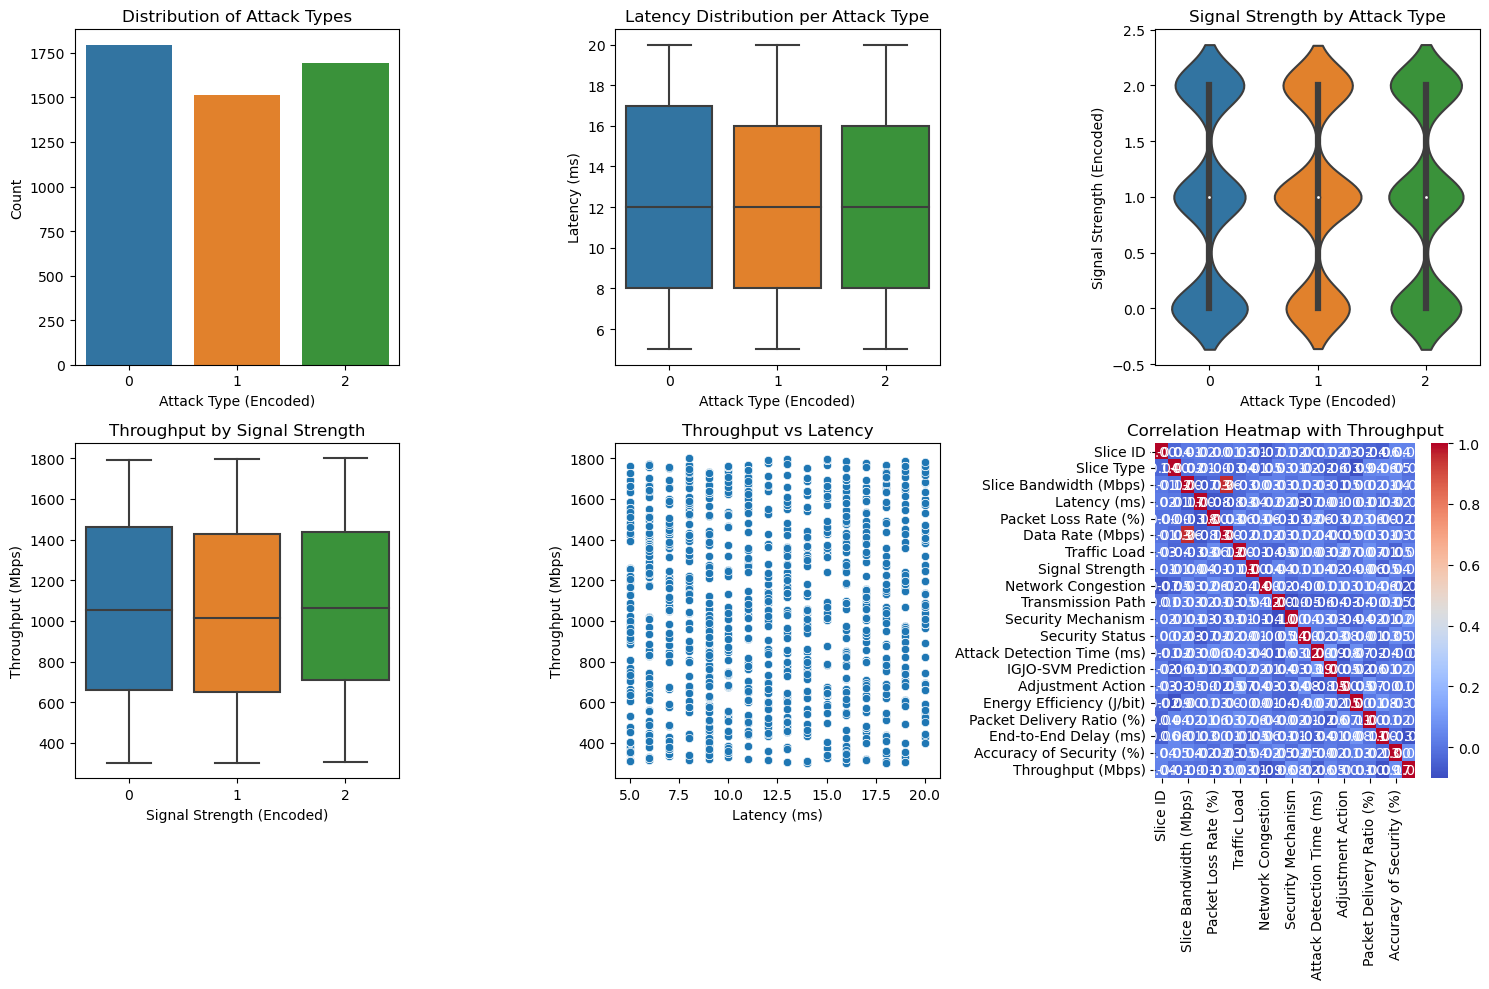

In [14]:
eda = perform_eda(X,y,y1)

In [15]:
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_splitdata(X, y, y1)

Loaded SVR model.

SVR Model Performance:
MAE: 0.3735
MSE: 18.8609
RMSE: 0.0043
R2 score: -0.0026


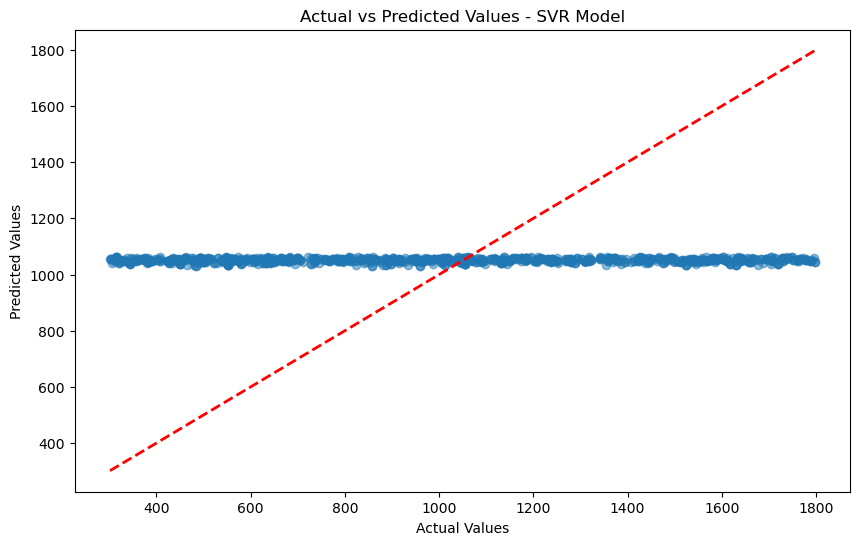

{'MAE': 0.3734735055074346,
 'MSE': 18.860927475568882,
 'RMSE': 0.004342916931691059,
 'R2 score': -0.002558893047900579}

In [16]:
 train_svm(X_train, y_reg_train, X_test, y_reg_test, mode="regressor")

Loaded SVC model.
SVC Model Accuracy  : 33.50
SVC Model Precision : 22.47
SVC Model Recall    : 32.25
SVC Model FScore    : 26.11
SVC Model Classification Report
SVC Model
               precision    recall  f1-score   support

         DDOS       0.35      0.38      0.36       359
Eavesdropping       0.00      0.00      0.00       303
     Spoofing       0.33      0.59      0.42       338

     accuracy                           0.34      1000
    macro avg       0.22      0.32      0.26      1000
 weighted avg       0.24      0.34      0.27      1000




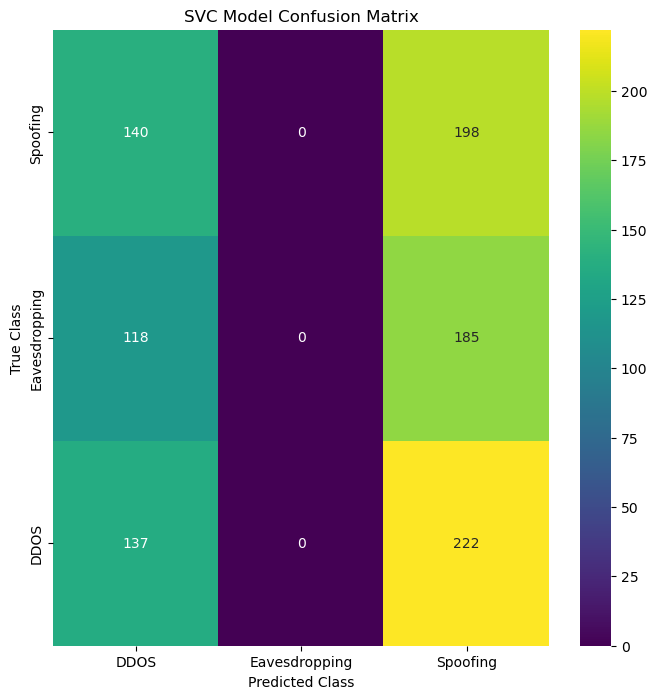

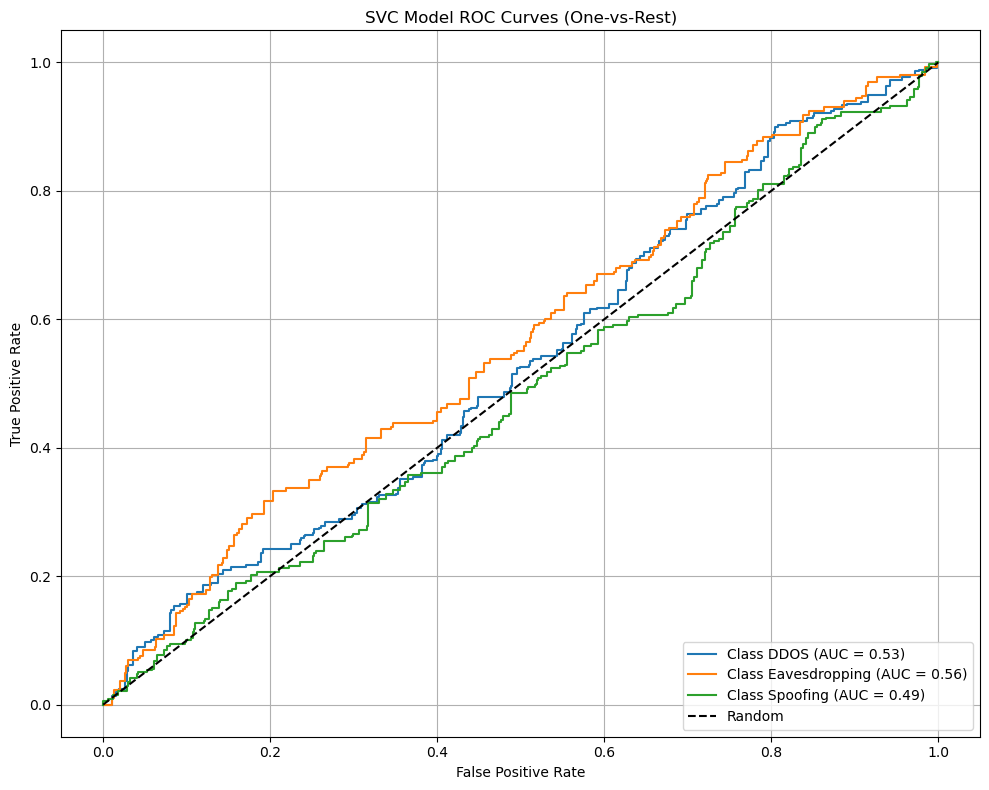

In [17]:
 train_svm(X_train,y_class_train,X_test,y_class_test, mode="Classifier")

Loaded Linear Regression model.

Linear Regression Performance:
MAE: 0.3695
MSE: 18.3870
RMSE: 0.0043
R2 score: 0.0226


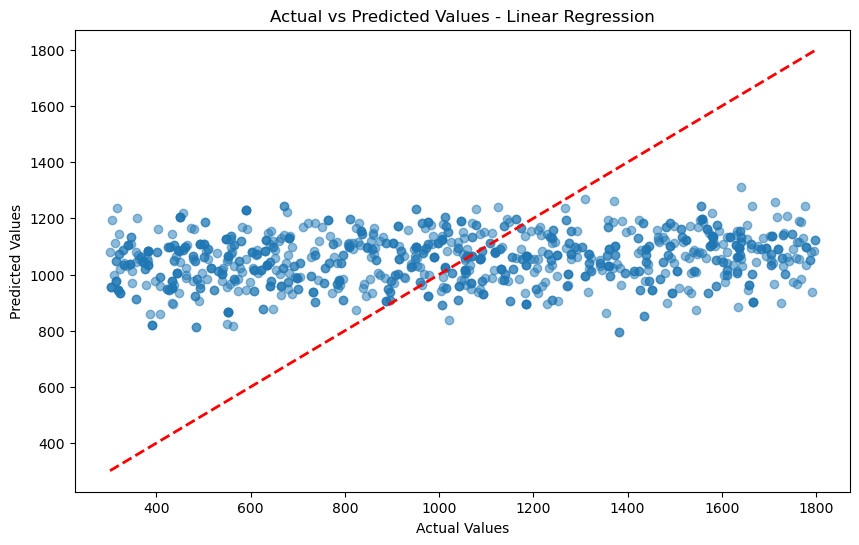

{'MAE': 0.3695357201361772,
 'MSE': 18.387013597236216,
 'RMSE': 0.004288008115341693,
 'R2 score': 0.022632157279644627}

In [18]:
train_linear_model(X_train, y_reg_train, X_test, y_reg_test, mode="regressor")

Loaded Linear (Logistic) Classifier model.
Linear (Logistic) Classifier Accuracy  : 35.00
Linear (Logistic) Classifier Precision : 33.17
Linear (Logistic) Classifier Recall    : 33.80
Linear (Logistic) Classifier FScore    : 31.80
Linear (Logistic) Classifier Classification Report
Linear (Logistic) Classifier
               precision    recall  f1-score   support

         DDOS       0.36      0.53      0.43       359
Eavesdropping       0.27      0.11      0.16       303
     Spoofing       0.36      0.37      0.37       338

     accuracy                           0.35      1000
    macro avg       0.33      0.34      0.32      1000
 weighted avg       0.33      0.35      0.33      1000




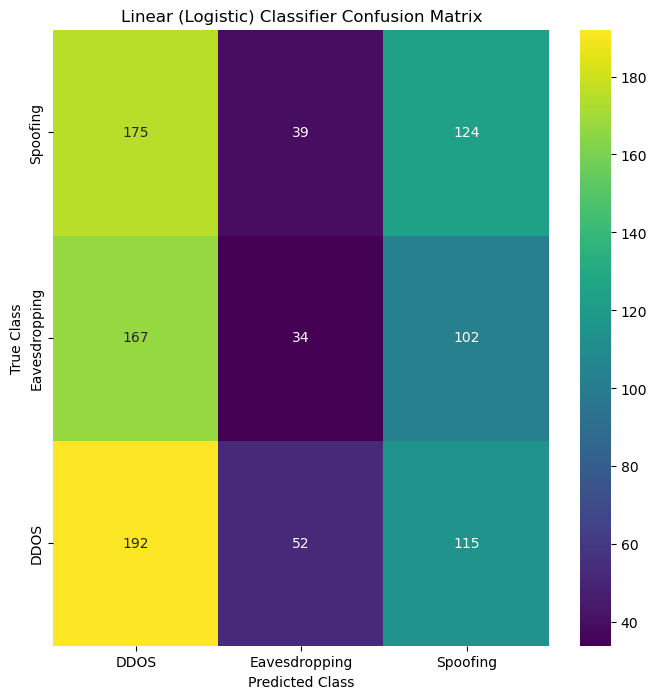

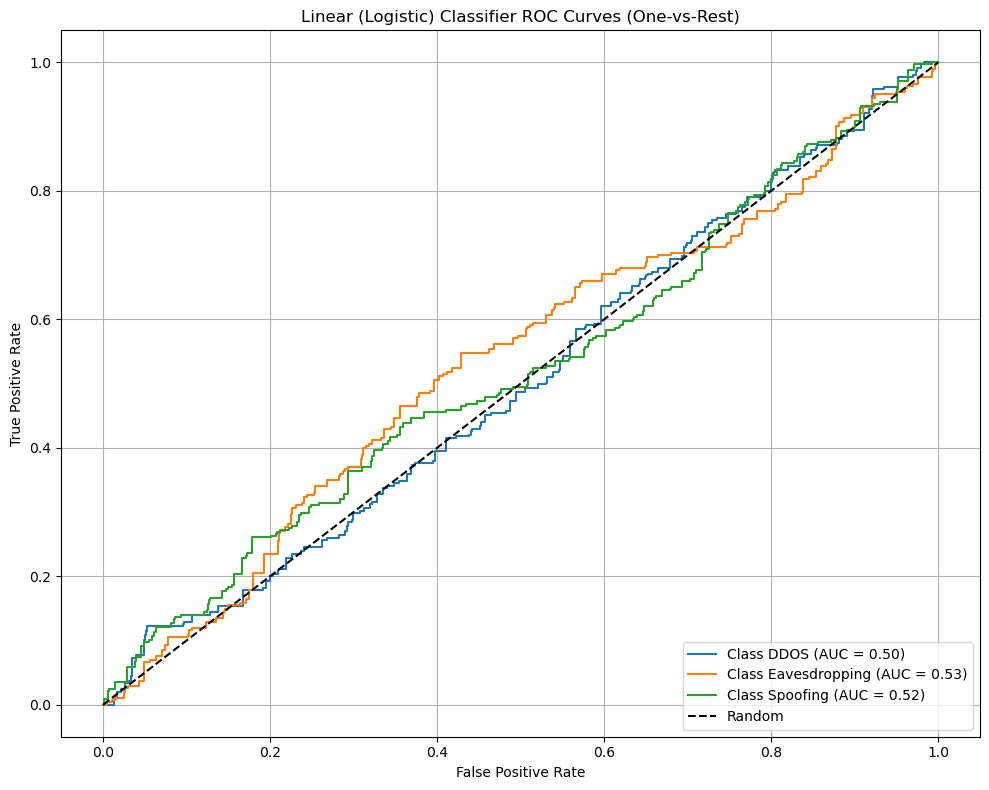

In [19]:
 train_linear_model(X_train,y_class_train,X_test,y_class_test, mode="Classifier")

Loaded KNN Regressor model.

KNN Regressor Performance:
MAE: 0.1365
MSE: 5.4631
RMSE: 0.0023
R2 score: 0.7096


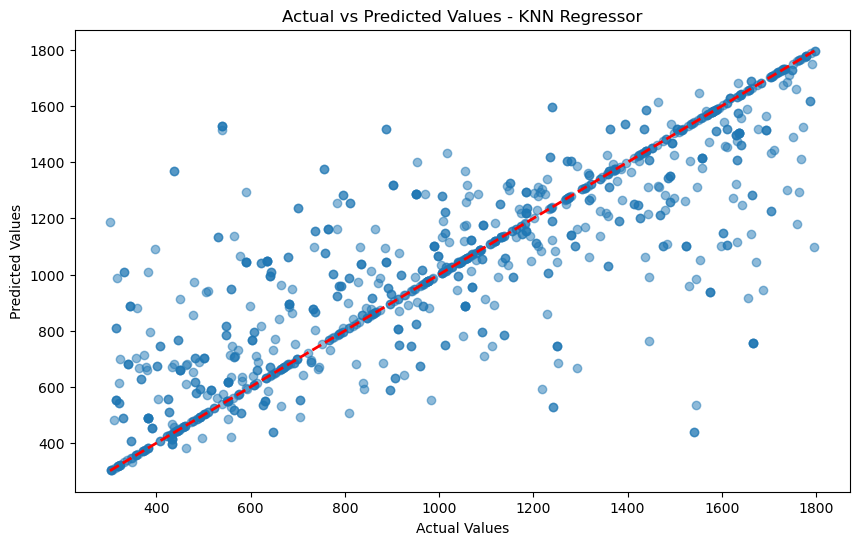

{'MAE': 0.13652649057942717,
 'MSE': 5.463060807601334,
 'RMSE': 0.002337319149710055,
 'R2 score': 0.7096091799824407}

In [20]:
 train_knn(X_train, y_reg_train, X_test, y_reg_test, mode="regressor")

Loaded KNN Classifier model.
KNN Classifier Accuracy  : 88.90
KNN Classifier Precision : 88.91
KNN Classifier Recall    : 88.86
KNN Classifier FScore    : 88.88
KNN Classifier Classification Report
KNN Classifier
               precision    recall  f1-score   support

         DDOS       0.88      0.88      0.88       359
Eavesdropping       0.89      0.87      0.88       303
     Spoofing       0.90      0.91      0.90       338

     accuracy                           0.89      1000
    macro avg       0.89      0.89      0.89      1000
 weighted avg       0.89      0.89      0.89      1000




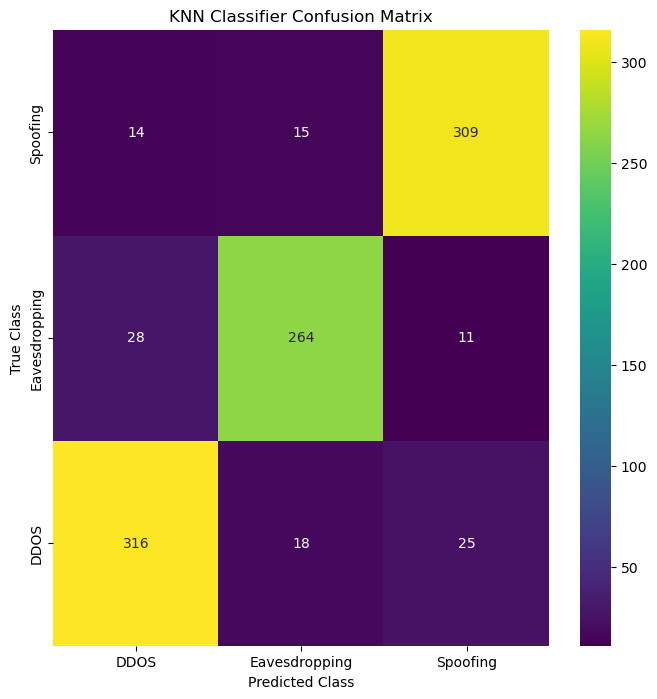

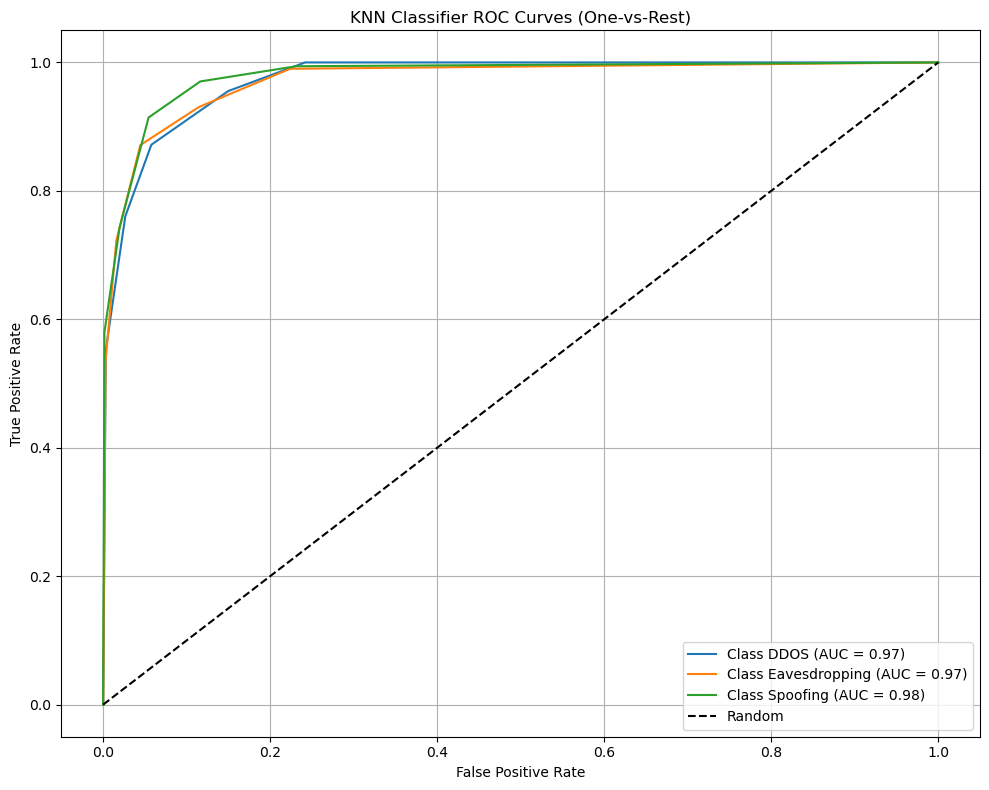

In [21]:
 train_knn(X_train,y_class_train,X_test,y_class_test, mode="Classifier")

Loaded FFNN feature extractor for regression.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Loaded Random Forest Regressor.

Hybrid FFNN + RFR Performance:
MAE: 0.0297
MSE: 0.6707
RMSE: 0.0008
R2 score: 0.9643


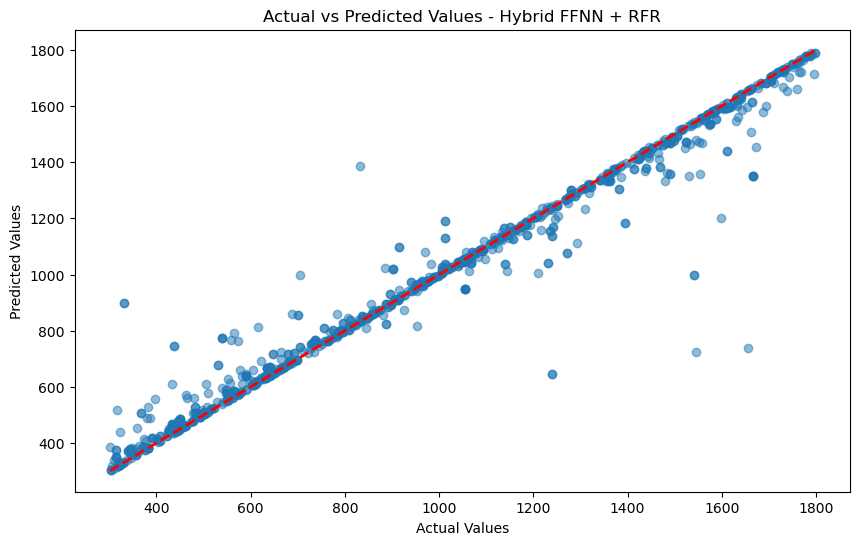

{'MAE': 0.029652583382572123,
 'MSE': 0.6707145856778015,
 'RMSE': 0.0008189716635377573,
 'R2 score': 0.9643479424095535}

In [22]:
train_hybrid_ffnn_rf(X_train, y_reg_train, X_test, y_reg_test, mode="regressor")

Loaded FFNN feature extractor for classification.
Loaded Random Forest Classifier.
Hybrid FFNN + RFC Accuracy  : 99.00
Hybrid FFNN + RFC Precision : 99.00
Hybrid FFNN + RFC Recall    : 98.99
Hybrid FFNN + RFC FScore    : 98.99
Hybrid FFNN + RFC Classification Report
Hybrid FFNN + RFC
               precision    recall  f1-score   support

         DDOS       0.99      0.99      0.99       359
Eavesdropping       0.99      0.99      0.99       303
     Spoofing       0.99      0.99      0.99       338

     accuracy                           0.99      1000
    macro avg       0.99      0.99      0.99      1000
 weighted avg       0.99      0.99      0.99      1000




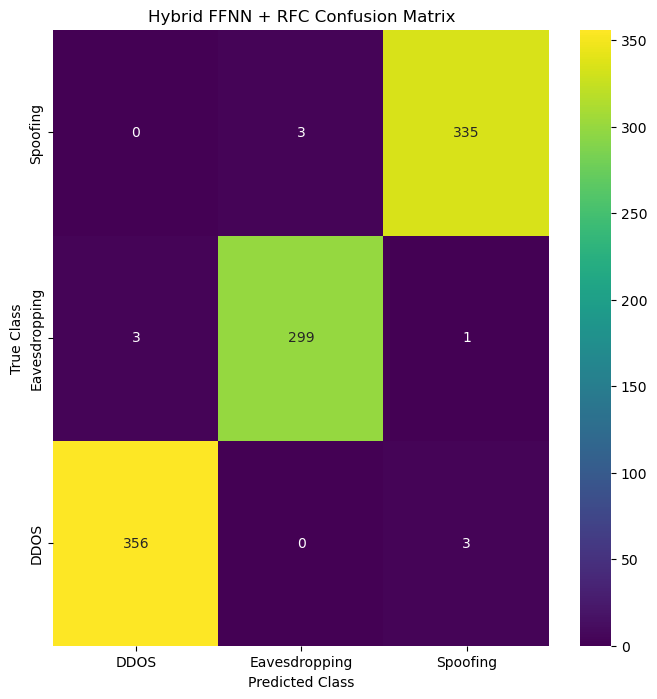

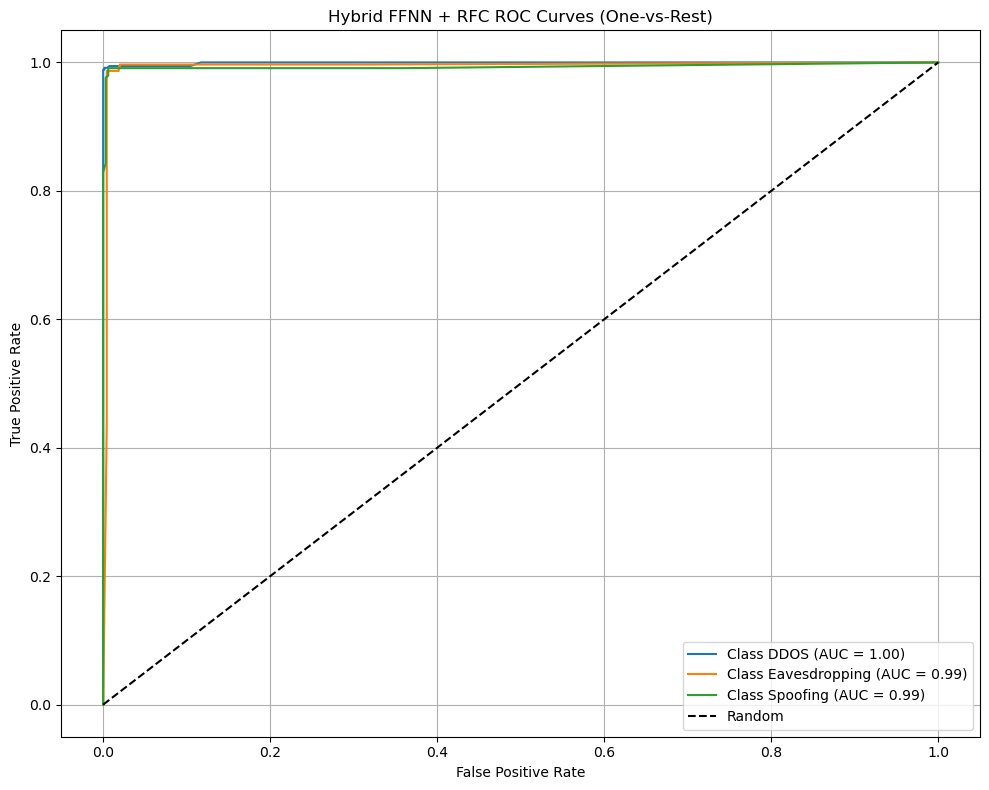

In [23]:
 train_hybrid_ffnn_rf(X_train,y_class_train,X_test,y_class_test, mode="Classifier",num_classes=3)

In [24]:
create_comparison_table()

,Model,MAE,MSE,RMSE,R2 Score
0,SVR Model,0.3735,18.8609,0.0043,-0.0026
1,Linear Regression,0.3695,18.3870,0.0043,0.0226
2,KNN Regressor,0.1365,5.4631,0.0023,0.7096
3,Hybrid FFNN + RFR,0.0297,0.6707,0.0008,0.9643


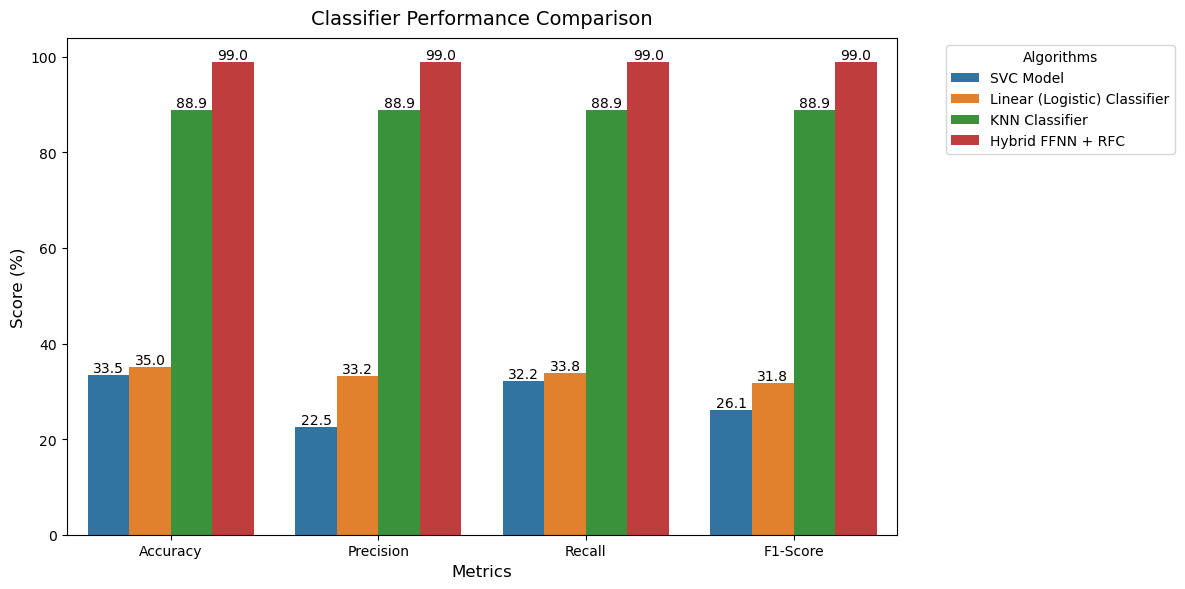

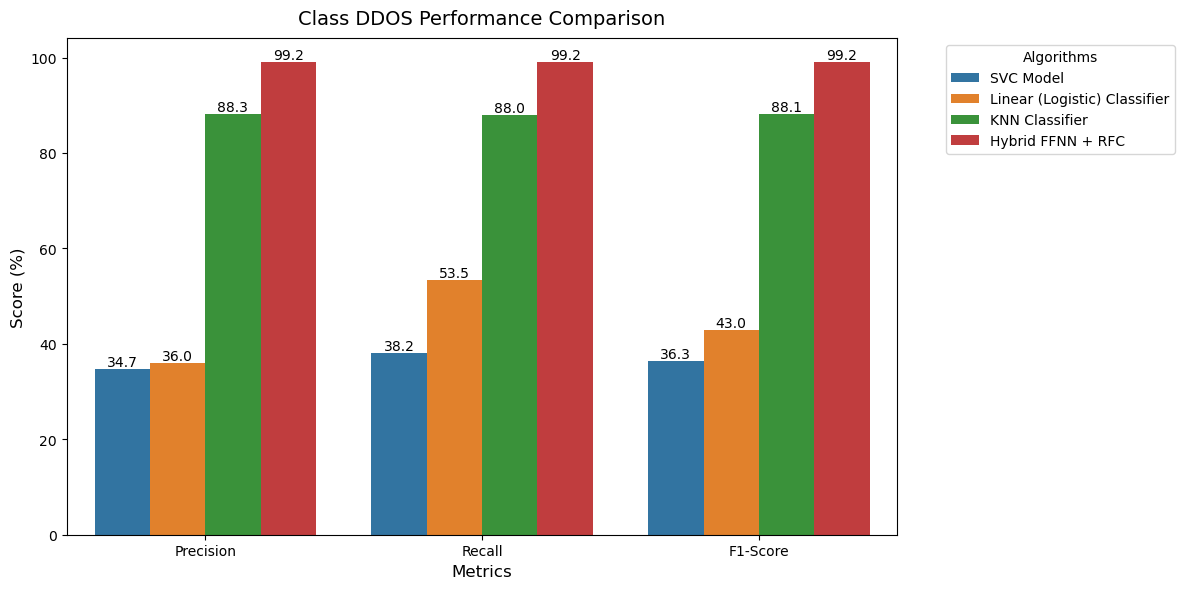

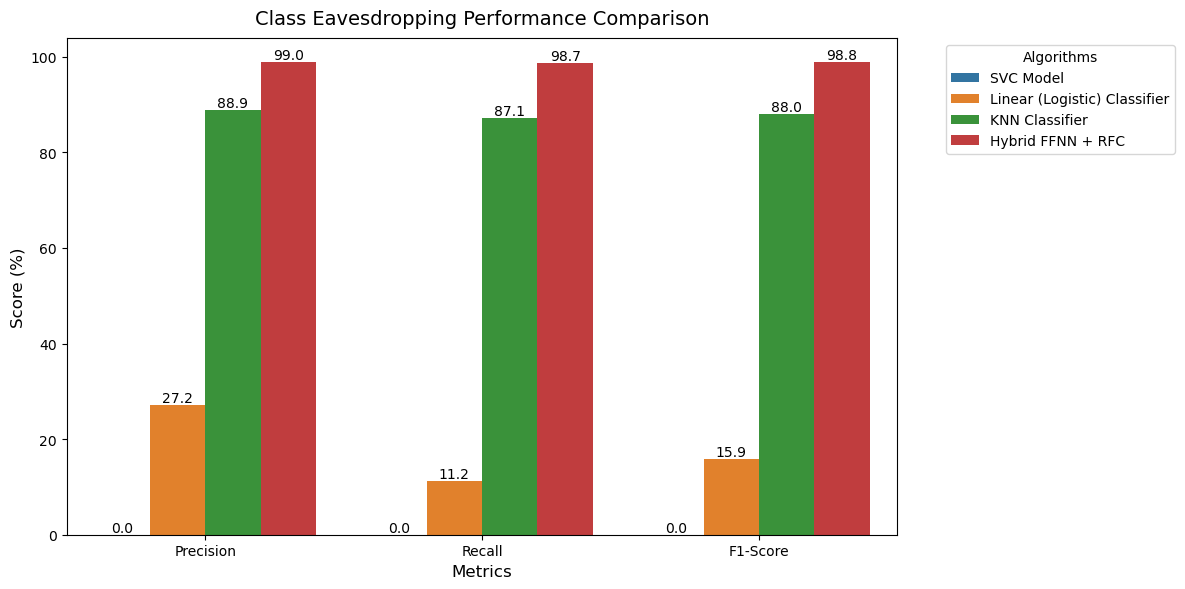

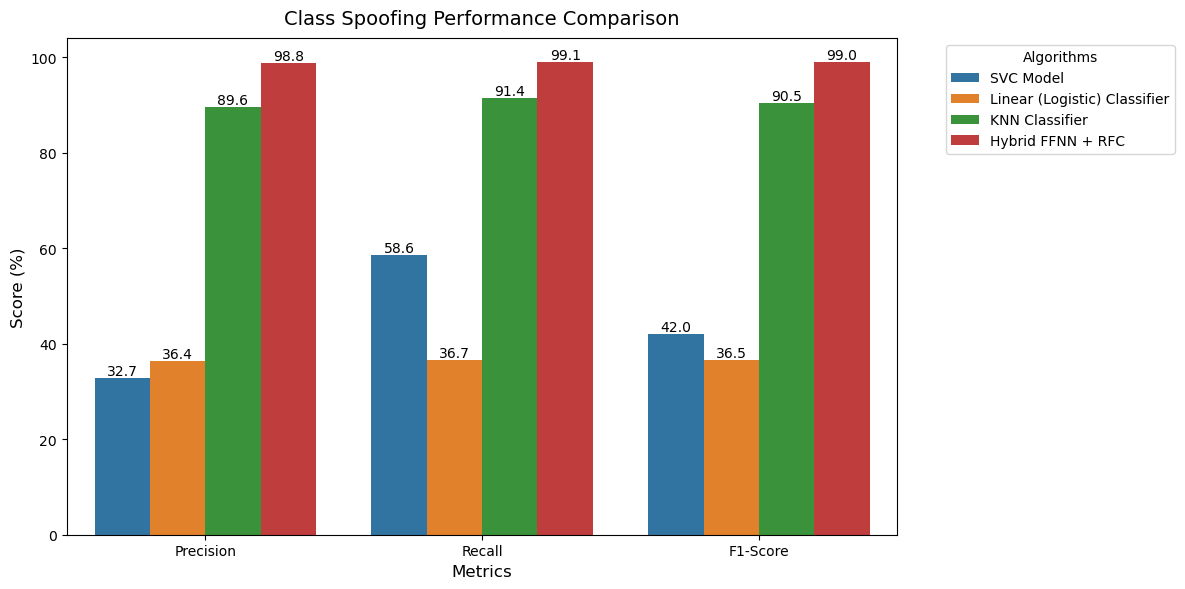

In [25]:
class_metrics= classification_graphs()

In [26]:
class_metrics

,Algorithm,Accuracy,Precision,Recall,F1-Score
0,SVC Model,33.5,22.470,32.247,26.111
1,Linear (Logistic) Classifier,35.0,33.173,33.796,31.804
2,KNN Classifier,88.9,88.907,88.857,88.876
3,Hybrid FFNN + RFC,99.0,98.997,98.986,98.991


## Test Data

In [27]:
test_data = pd.read_csv('TestData.csv')
test_data

,Slice ID,Slice Type,Slice Bandwidth (Mbps),Latency (ms),Packet Loss Rate (%),Data Rate (Mbps),Traffic Load,Signal Strength,Network Congestion,Transmission Path,Security Mechanism,Security Status,Attack Detection Time (ms),IGJO-SVM Prediction,Adjustment Action,Energy Efficiency (J/bit),Packet Delivery Ratio (%),End-to-End Delay (ms),Accuracy of Security (%)
0,103,Ultra-High-Speed,644,20,0.044122,457,Medium,Strong,Medium,Path A,Encryption,Yes,88,0.784537,Optimize Path,0.025629,90.949866,15,92.345441
1,861,IoT,1759,14,0.058662,1297,Low,Strong,Low,Path A,Encryption,Yes,61,0.927561,Alert Admin,0.015082,95.697079,25,97.571666
2,271,Autonomous,784,19,0.176483,621,Medium,Strong,Medium,Path B,Encryption,No,57,0.742899,Alert Admin,0.037527,91.025846,23,90.478111
3,107,Autonomous,1320,13,0.186623,849,High,Weak,Medium,Path C,Encryption,Yes,50,0.830193,Alert Admin,0.039606,91.581326,16,98.203450
4,615,Ultra-High-Speed,510,13,0.113875,248,High,Weak,Low,Path A,Encryption,Yes,98,0.552161,Alert Admin,0.032306,92.197503,23,92.094284
5,467,Autonomous,795,17,0.026298,707,Low,Moderate,Medium,Path C,Encryption,No,67,0.478971,Increase Security,0.016587,93.425988,26,90.633192
6,215,IoT,701,18,0.091848,381,High,Weak,High,Path C,IDS,Yes,76,0.356367,Alert Admin,0.025265,90.517209,10,96.697230
7,459,IoT,1457,16,0.123413,1135,Medium,Weak,Low,Path C,Encryption,Yes,61,0.588586,Alert Admin,0.027704,97.837030,15,91.105014
8,100,Autonomous,642,16,0.065639,267,Low,Weak,Low,Path A,IDS,Yes,52,0.897529,Alert Admin,0.033076,91.000317,22,90.787821
9,309,Ultra-High-Speed,812,14,0.069588,622,Medium,Moderate,Low,Path A,IDS,Yes,42,0.139297,Increase Security,0.034009,90.379978,23,93.507185


In [28]:
df1=preprocess_data(test_data, is_train=False,label_encoders=label_vamshi)

In [29]:
df1

,Slice ID,Slice Type,Slice Bandwidth (Mbps),Latency (ms),Packet Loss Rate (%),Data Rate (Mbps),Traffic Load,Signal Strength,Network Congestion,Transmission Path,Security Mechanism,Security Status,Attack Detection Time (ms),IGJO-SVM Prediction,Adjustment Action,Energy Efficiency (J/bit),Packet Delivery Ratio (%),End-to-End Delay (ms),Accuracy of Security (%)
0,103,2,644,20,0.044122,457,2,1,2,0,0,1,88,0.784537,2,0.025629,90.949866,15,92.345441
1,861,1,1759,14,0.058662,1297,1,1,1,0,0,1,61,0.927561,0,0.015082,95.697079,25,97.571666
2,271,0,784,19,0.176483,621,2,1,2,1,0,0,57,0.742899,0,0.037527,91.025846,23,90.478111
3,107,0,1320,13,0.186623,849,0,2,2,2,0,1,50,0.830193,0,0.039606,91.581326,16,98.203450
4,615,2,510,13,0.113875,248,0,2,1,0,0,1,98,0.552161,0,0.032306,92.197503,23,92.094284
5,467,0,795,17,0.026298,707,1,0,2,2,0,0,67,0.478971,1,0.016587,93.425988,26,90.633192
6,215,1,701,18,0.091848,381,0,2,0,2,2,1,76,0.356367,0,0.025265,90.517209,10,96.697230
7,459,1,1457,16,0.123413,1135,2,2,1,2,0,1,61,0.588586,0,0.027704,97.837030,15,91.105014
8,100,0,642,16,0.065639,267,1,2,1,0,2,1,52,0.897529,0,0.033076,91.000317,22,90.787821
9,309,2,812,14,0.069588,622,2,0,1,0,2,1,42,0.139297,1,0.034009,90.379978,23,93.507185


In [30]:
def predict_classifier_and_regressor(
        samp_cls,          # pre‑processed sample(s) for classification
        samp_reg,          # pre‑processed sample(s) for regression
        return_proba=True  # set False if you don’t need class‑probabilities
    ):



    # ---------- paths ----------
    cls_ffnn_path = os.path.join("models", "ffnn_classification_model.h5")
    cls_rfc_path  = os.path.join("models", "hybrid_rfc_model.joblib")
    reg_ffnn_path = os.path.join("models", "ffnn_regression_model.h5")
    reg_rfr_path  = os.path.join("models", "hybrid_rfr_model.joblib")

        
    # ---------- load models ----------
    ffnn_cls = load_model(cls_ffnn_path)
    rfc      = joblib.load(cls_rfc_path)

    ffnn_reg = load_model(reg_ffnn_path)
    rfr      = joblib.load(reg_rfr_path)

    # ---------- extract features ----------
    # • classification: use penultimate layer as in your original code
    feat_extractor_cls = Model(inputs=ffnn_cls.input,
                               outputs=ffnn_cls.layers[-2].output)
    f_cls = feat_extractor_cls.predict(samp_cls)

    # • regression: use last hidden layer (adapt if needed)
    feat_extractor_reg = Model(inputs=ffnn_reg.input,
                               outputs=ffnn_reg.layers[-2].output)
    f_reg = feat_extractor_reg.predict(samp_reg)

    # ---------- predict ----------
    Y_classifier = rfc.predict(f_cls)
    class_proba  = rfc.predict_proba(f_cls) if return_proba else None
    Y_regression = rfr.predict(f_reg)

    return (Y_classifier, class_proba, Y_regression) if return_proba \
           else (Y_classifier, Y_regression)

In [31]:
Y_cls, cls_prob, Y_reg = predict_classifier_and_regressor( df1, df1, return_proba=True)

In [32]:
attack_type_le = label_vamshi["Attack Type"]
Y_cls_names = attack_type_le.inverse_transform(Y_cls)


## Prediction on Test Data

In [33]:
for i in range(len(df1)):
    print("Sample Test Data:")
    # Print each column name and its value for the current row
    for col in df1.columns:
        print(f"{col}: {df1.iloc[i][col]}")
    # Print the predicted class (from y_pred, named 'output')
    BOLD = '\033[1m'
    END = '\033[0m'
    print(f"{BOLD}Attack Classified As ===> {Y_cls_names[i]}{END}")
    print(f"{BOLD}Predicted Throughput Value: {Y_reg[i]}{END}")
    print("\n\n\n\n\n")

Sample Test Data:
Slice ID: 103.0
Slice Type: 2.0
Slice Bandwidth (Mbps): 644.0
Latency (ms): 20.0
Packet Loss Rate (%): 0.044122391
Data Rate (Mbps): 457.0
Traffic Load: 2.0
Signal Strength: 1.0
Network Congestion: 2.0
Transmission Path: 0.0
Security Mechanism: 0.0
Security Status: 1.0
Attack Detection Time (ms): 88.0
IGJO-SVM Prediction: 0.784536519
Adjustment Action: 2.0
Energy Efficiency (J/bit): 0.025628698
Packet Delivery Ratio (%): 90.94986645
End-to-End Delay (ms): 15.0
Accuracy of Security (%): 92.34544101
Attack Classified As ===> DDoS
Predicted Throughput Value: 399.94199761556223






Sample Test Data:
Slice ID: 861.0
Slice Type: 1.0
Slice Bandwidth (Mbps): 1759.0
Latency (ms): 14.0
Packet Loss Rate (%): 0.058661722
Data Rate (Mbps): 1297.0
Traffic Load: 1.0
Signal Strength: 1.0
Network Congestion: 1.0
Transmission Path: 0.0
Security Mechanism: 0.0
Security Status: 1.0
Attack Detection Time (ms): 61.0
IGJO-SVM Prediction: 0.927561349
Adjustment Action: 0.0
Energy Efficienc

In [34]:
output_data = []  # List to collect dictionaries of each row's data

for i in range(len(df1)):
    row_data = {}
    
    # Add test data columns and values
    for col in df1.columns:
        row_data[col] = df1.iloc[i][col]
    
    # Add classification and regression output
    row_data['Attack_Classified_As'] = Y_cls_names[i]
    row_data['Predicted_Throughput_Value'] = Y_reg[i]
    
    output_data.append(row_data)

# Create DataFrame
output_df = pd.DataFrame(output_data)
output_df

,Slice ID,Slice Type,Slice Bandwidth (Mbps),Latency (ms),Packet Loss Rate (%),Data Rate (Mbps),Traffic Load,Signal Strength,Network Congestion,Transmission Path,...,Security Status,Attack Detection Time (ms),IGJO-SVM Prediction,Adjustment Action,Energy Efficiency (J/bit),Packet Delivery Ratio (%),End-to-End Delay (ms),Accuracy of Security (%),Attack_Classified_As,Predicted_Throughput_Value
0,103.0,2.0,644.0,20.0,0.044122,457.0,2.0,1.0,2.0,0.0,...,1.0,88.0,0.784537,2.0,0.025629,90.949866,15.0,92.345441,DDoS,399.941998
1,861.0,1.0,1759.0,14.0,0.058662,1297.0,1.0,1.0,1.0,0.0,...,1.0,61.0,0.927561,0.0,0.015082,95.697079,25.0,97.571666,DDoS,586.560332
2,271.0,0.0,784.0,19.0,0.176483,621.0,2.0,1.0,2.0,1.0,...,0.0,57.0,0.742899,0.0,0.037527,91.025846,23.0,90.478111,DDoS,1170.823671
3,107.0,0.0,1320.0,13.0,0.186623,849.0,0.0,2.0,2.0,2.0,...,1.0,50.0,0.830193,0.0,0.039606,91.581326,16.0,98.203450,DDoS,964.880162
4,615.0,2.0,510.0,13.0,0.113875,248.0,0.0,2.0,1.0,0.0,...,1.0,98.0,0.552161,0.0,0.032306,92.197503,23.0,92.094284,DDoS,1444.509610
5,467.0,0.0,795.0,17.0,0.026298,707.0,1.0,0.0,2.0,2.0,...,0.0,67.0,0.478971,1.0,0.016587,93.425988,26.0,90.633192,DDoS,549.621426
6,215.0,1.0,701.0,18.0,0.091848,381.0,0.0,2.0,0.0,2.0,...,1.0,76.0,0.356367,0.0,0.025265,90.517209,10.0,96.697230,DDoS,1289.560976
7,459.0,1.0,1457.0,16.0,0.123413,1135.0,2.0,2.0,1.0,2.0,...,1.0,61.0,0.588586,0.0,0.027704,97.837030,15.0,91.105014,DDoS,921.101739
8,100.0,0.0,642.0,16.0,0.065639,267.0,1.0,2.0,1.0,0.0,...,1.0,52.0,0.897529,0.0,0.033076,91.000317,22.0,90.787821,DDoS,561.554597
9,309.0,2.0,812.0,14.0,0.069588,622.0,2.0,0.0,1.0,0.0,...,1.0,42.0,0.139297,1.0,0.034009,90.379978,23.0,93.507185,DDoS,1424.892856
